# Quantum Algorithm for Solving The 1D Heat Equation

The Heat Equation is a fundamental partial differential equation (PDE) describing how heat diffuses through a medium over time. It is widely used in physics and engineering applications. Mathematically, it is expressed as:

$$
\frac{\partial u}{\partial t} = \alpha \nabla^2 u,
$$

where $$\ u(x, t) $$ is the temperature, $ \alpha$ is the thermal diffusivity, and $ \nabla^2 $ is the Laplacian operator.
The initial condition defines the temperature profile at \( t = 0 \), while the boundary conditions describe the time-varying temperature at the rod's ends.


In this notebook, we will solve the Heat Equation using the **Quantum Singular Value Transformation (QSVT)** algorithm. The Heat Equation will first be discretized into a linear system, and then QSVT will be applied to approximate its solution.

## Example
Let 1D stick of length L, the temperature distribution at time t = 0 (initial condition) and the temperature at the boundaries are constant and equal to 0 as formulated below:

### Initial Condition
$
u(x, 0) = \sin(\pi x), \quad x \in [0, L]
$

### Boundary Conditions
- **Left Boundary:**
$
u(0, t) = 0
$

- **Right Boundary:**
$
u(L, t) = 0
$

We wish to predict what is the temperature distribution at time $t_n$ given the intial and boundary conditions descrbied above.

In [1]:
import numpy as np

M = 8  # Make this bigger according to 18 qubits limit total
TIME_STEPS = 1024  # might have to be smaller, like 4...
start_time = 0
end_time = 0.5
start_position = 0
end_position = 1
dx = (end_position - start_position) / M
dt = (end_time - start_time) / TIME_STEPS
alpha = 1
assert dt <= alpha * dx**2

t = np.linspace(start_time, end_time, TIME_STEPS)
x = np.linspace(start_position, end_position, M)

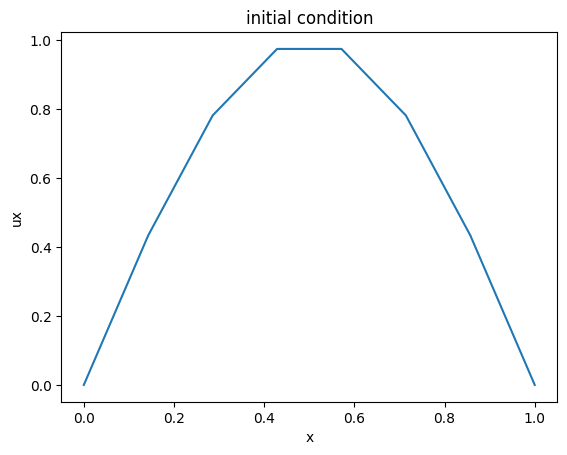

In [2]:
# Intial Conditions
ux = np.sin(np.pi * x)

# Print the initial definitions
import matplotlib.pyplot as plt

plt.figure()
plt.title("initial condition")
plt.plot(x, ux)
plt.ylabel("ux")
plt.xlabel("x")
plt.show()

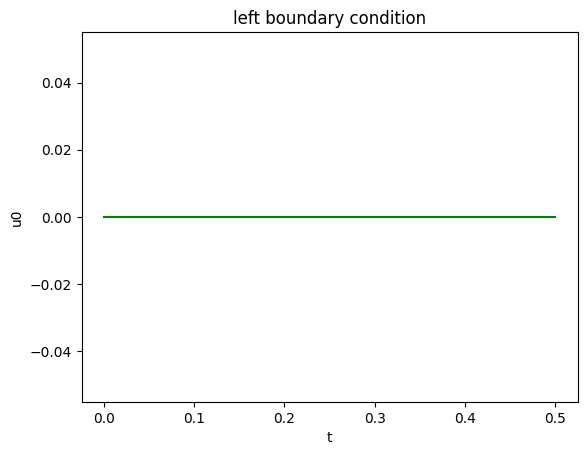

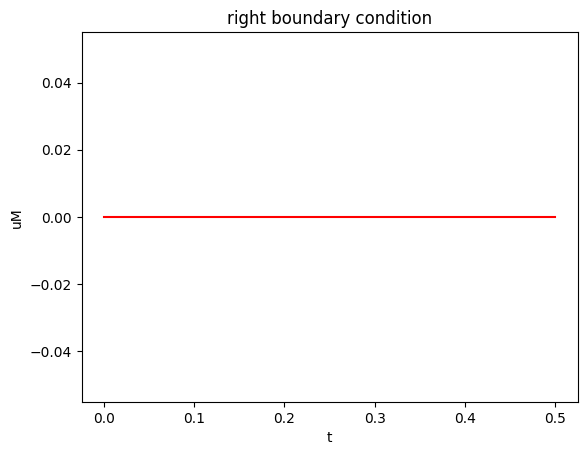

In [3]:
# Boundary Conditions
u0 = 0 * t
uM = 0 * t
plt.figure()
plt.title("left boundary condition")
plt.plot(t, u0, color="green")
plt.ylabel("u0")
plt.xlabel("t")
plt.show()

plt.figure()
plt.title("right boundary condition")
plt.plot(t, uM, color="red")
plt.ylabel("uM")
plt.xlabel("t")
plt.show()

### Discretization of the Heat Equation

To solve the Heat Equation numerically, we discretize it using the **finite difference method**. In one spatial dimension:

$$
\frac{\partial u}{\partial t} \approx \frac{u_i^{n+1} - u_i^n}{\Delta t}, \quad
\frac{\partial^2 u}{\partial x^2} \approx \frac{u_{i+1}^n - 2u_i^n + u_{i-1}^n}{\Delta x^2}.
$$

Substituting these into the Heat Equation gives:

$$
\frac{u_i^{n+1} - u_i^n}{\Delta t} = \alpha \frac{u_{i+1}^n - 2u_i^n + u_{i-1}^n}{\Delta x^2}.
$$

Rearranging terms, we obtain:

$$
u_i^{n+1} = u_i^n + \frac{\alpha \Delta t}{\Delta x^2} \left( u_{i+1}^n - 2u_i^n + u_{i-1}^n \right).
$$

This can be expressed in matrix form as:

$$
A \mathbf{u}^{n+1} = \mathbf{b}^{n},
$$

where $ A $ is a matrix derived from the discretization, and $ \mathbf{b} $ represents the system's state at the current time step. The goal is to compute $ \mathbf{u}^{n+1} $, the state at the next time step.



#### **Matrix \( A \) and Vector \( b \): Discretization of the Heat Equation**

To solve the 1D heat equation numerically, we discretize it using the **finite difference method**. The resulting system can be written as:

$
A \mathbf{u}^{n+1} = \mathbf{b},
$
where:
- $ A $ is the **system matrix** derived from the discretization of the second spatial derivative using a tri-diagonal structure.
- $ \mathbf{b} $ includes contributions from the **initial conditions** and **boundary conditions**.

#### **Construction of Matrix \( L \):**
The Laplacian operator $ L $ is represented as a tri-diagonal matrix:

$
L = 
\begin{bmatrix}
2 & -1 & 0 & \cdots & 0 \\
-1 & 2 & -1 & \cdots & 0 \\
0 & -1 & 2 & \cdots & 0 \\
\vdots & \vdots & \vdots & \ddots & -1 \\
0 & 0 & 0 & -1 & 2
\end{bmatrix}
$

#### **Matrix \( A \):**
Using the time step $ \Delta t $ and spatial step $ \Delta x $, the system matrix $ A $ is constructed as:

$
A = I + \alpha \frac{\Delta t}{\Delta x^2} L,
$
where $ I $ is the identity matrix.

#### **Visualization of Matrix \( A \):**
The following code generates a matrix $ A $, constructs the vector $ b $ for the initial and boundary conditions, and visualizes $ A $:

1. **Initial Conditions:** $ u(x, 0) = \sin(\pi x) $


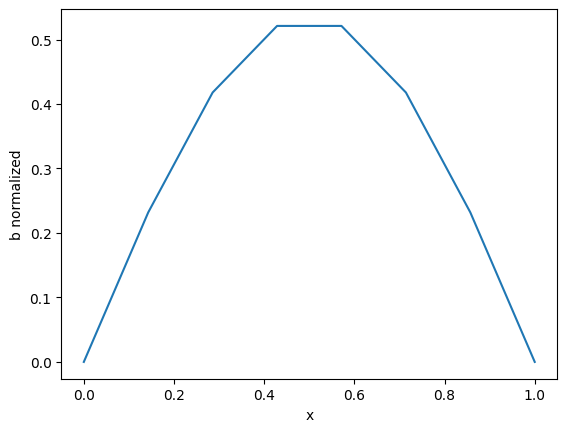

In [4]:
L = (
    2 * np.diag(np.ones(M))
    + -1 * np.diag(np.ones(M - 1), 1)
    + -1 * np.diag(np.ones(M - 1), -1)
)
A = np.eye(M) + alpha * dt / dx**2 * L  # dt/dx**2*
# A_norm = 1/0.54215392 * A
initial_conditions = ux
boundary_conditions = 0 * ux
boundary_conditions[0] = u0[0]
boundary_conditions[-1] = uM[0]
b = initial_conditions + alpha * dt / dx**2 * boundary_conditions
norm_factor = np.linalg.norm(b)
b_normalized = b / norm_factor
import matplotlib.pyplot as plt

plt.plot(x, b_normalized)
plt.xlabel("x")
plt.ylabel("b normalized")
plt.show()

[[ 1.0625  -0.03125  0.       0.       0.       0.       0.       0.     ]
 [-0.03125  1.0625  -0.03125  0.       0.       0.       0.       0.     ]
 [ 0.      -0.03125  1.0625  -0.03125  0.       0.       0.       0.     ]
 [ 0.       0.      -0.03125  1.0625  -0.03125  0.       0.       0.     ]
 [ 0.       0.       0.      -0.03125  1.0625  -0.03125  0.       0.     ]
 [ 0.       0.       0.       0.      -0.03125  1.0625  -0.03125  0.     ]
 [ 0.       0.       0.       0.       0.      -0.03125  1.0625  -0.03125]
 [ 0.       0.       0.       0.       0.       0.      -0.03125  1.0625 ]]


Text(0.5, 1.0, 'A matrix')

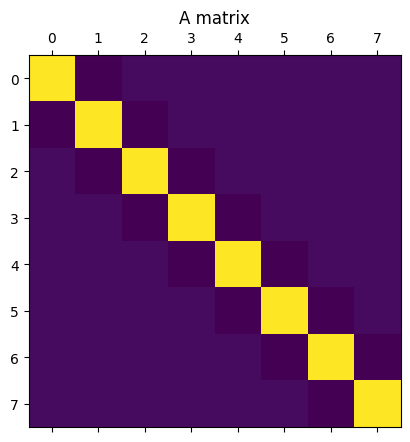

In [5]:
print(A)
plt.matshow(A)
plt.title("A matrix")

## Problem formulation

$ u^n - $ is the vector representation of the temperature of the stick at time n.
$ u^n = [u_0^n, u_1^n, \cdots, u_M^n]^T$

$ b^n - $ is the sum of the trmperature at time n-1 and boundary condition at time n.
$ b^n = [b_0^n, b_1^n, \cdots, b_M^n]^T$

$ A - $ Problem operator define as the sum of Laplacian operator multiplied by discret operator and identity.

So, we state the temperature at time n as a linear problem depends on time n-1 and the problem operator:

$ Au^n = b^n $

Suppose we aim to predict the temperatue distribution at time n.

1. **Problem initialization:**
    - $u^0=$ defined by initial condition.
    - $b^1=$ define as the sum of $u^0$ and the boundary condition.

2. **Main loop:**

    **for any i until n:**
    - $u^i = A^{-1} b^i$ 
    - $b^{i+1} = u^i + boundary condition$

Suppose we have quantum registers b and u holding the input and the result at each iteration. as stated above, first prepering the state of 
register b such that it holds the vector b (b must be normalisied)appling repitatlly QSVT circuit to compute u at time n.   



 



In [6]:
!pip install -qq "classiq[qsp]"

In [7]:
import numpy as np
from numpy.polynomial import Polynomial
from pyqsp.angle_sequence import QuantumSignalProcessingPhases

from classiq import *
from classiq.execution import ClassiqBackendPreferences, ExecutionPreferences

In [8]:
def get_qprog(main, constraints=None, preferences=Preferences(transpilation_option="none", timeout_seconds=600, optimization_level=0)) -> str:  # type: ignore[no-untyped-def]
    """
    This function gets a model and synthesizes it. It also sets the execution on a statevector
    """
    execution_preferences = ExecutionPreferences(
        num_shots=1,
        backend_preferences=ClassiqBackendPreferences(
            backend_name=ClassiqSimulatorBackendNames.SIMULATOR_STATEVECTOR
        ),
    )
    qmod = create_model(
        main,
        execution_preferences=execution_preferences,
        constraints=constraints,
        preferences=preferences,
    )
    qmod = set_execution_preferences(qmod, execution_preferences)
    qprog = synthesize(qmod)
    return qprog


def get_projected_state_vector(  # type: ignore[no-untyped-def]
    execution_result,
    measured_var: str,
) -> np.ndarray:
    """
    This function returns a reduced statevector from execution results.
    measured var: the name of the reduced variable
    """
    projected_size = len(execution_result.output_qubits_map[measured_var])
    proj_statevector = np.zeros(2**projected_size).astype(complex)
    df = execution_result.dataframe
    filtered_st = df[np.abs(df.amplitude) > 1e-12]

    # Allocate values
    proj_statevector[filtered_st[measured_var]] = filtered_st.amplitude

    # global phase
    indices = np.where(np.abs(proj_statevector) > 1e-13)[0]  # Get non-zero indices
    if indices.shape[0] == 0:
        return np.zeros(2**projected_size)  # return zero state
    first_non_zero_entry = indices[0]
    global_phase = np.angle(proj_statevector[first_non_zero_entry])
    return np.real(proj_statevector / np.exp(1j * global_phase))

# Block encoding

### What is Quantum Block Encoding?

Quantum block encoding is a method in quantum computing used to embed a matrix or operator into a unitary matrix that can be implemented efficiently on a quantum computer. This technique is essential for quantum algorithms that require matrix operations, such as quantum machine learning, quantum linear algebra etc...

THe starting point of QSVT is the availability of matrix A encoded as a block inside larger unitary operator U, when A is already unitary matrix BE become simply controlled-A.

### How to Block encode the matrix A of heat equation?

BE utilies the structure of the matrix A for building a quntum circuit representation (unitary operator) of matrix A.

Condier matrix A has Toeplitz structure with D digonals, offset from the main diagonal by k:

$$
\left(
\begin{array}{ccccccc}
A_k & A_{k-1} & \cdots & A_0 &        &        &   \\
A_{k+1} & A_k & A_{k-1} & \cdots & A_0 &        &   \\
\vdots & A_{k+1} & A_k & A_{k-1} & \cdots & A_0 &   \\
A_{D-1} & \vdots & A_{k+1} & A_k & A_{k-1} & \cdots & A_0 \\
       & A_{D-1} & \vdots & A_{k+1} & A_k & A_{k-1} & \cdots \\
       &        & \ddots & \vdots & A_{k+1} & A_k & A_{k-1} \\
       &        &        & A_{D-1} & \cdots & A_{k+1} & A_k
\end{array}
\right)
$$  

Specifically, A of our probles is Toeplitz matrix with 3 diagonals offset by k = 1:

$$
\left(
\begin{array}{ccccccc}
1+\frac{\alpha \Delta t}{\Delta x ^ 2}2 & -\frac{\alpha\Delta t}{\Delta x ^ 2}  &         &        &   \\
\frac{-\alpha\Delta t}{\Delta x ^ 2} & 1 + \frac{\alpha \Delta t}{\Delta x ^ 2} 2 & \frac{-\alpha\Delta t}{\Delta x ^ 2} &        &   \\
   & \frac{-\alpha\Delta t}{\Delta x ^ 2} &  1 + \frac{\alpha\Delta t}{\Delta x ^ 2} 2 &\frac{-\alpha\Delta t}{\Delta x ^ 2} &   \\
   & \ddots   & \ddots & \ddots &    \\
   &  &\ddots   & \ddots & \ddots &    \\
   &    &    &  \frac{-\alpha\Delta t}{\Delta x ^ 2} &  1 + \frac{\alpha\Delta t}{\Delta x ^ 2} 2 & \frac{-\alpha\Delta t}{\Delta x ^ 2}
\end{array}
\right)
$$  

Lets set $ \alpha = \frac{\Delta x ^ 2}{\Delta t} $ so matrix A is:

$$
\left(
\begin{array}{ccccccc}
3 & -1  &         &        &   \\
-1 & 3 & -1 &        &   \\
   & -1 &  3 & -1 &   \\
   & \ddots   & \ddots & \ddots &    \\
   &  &\ddots   & \ddots & \ddots &    \\
   &    &    &  -1 &  3 & -1
\end{array}
\right)
$$  

Consider the mapping between (d,m) -> (i,j) where,
(i,j) are the indices in matrix coordinates.
(d,m) are the distinctiy and multiplicity of the values in A.

i(d,m) = d - k + m.
j(d,m) = m.

Those mappings allows us to apply controlled rotation operator depending on the parameter d (superposition of posibilties of disdinct values), 
While m is simply the input state |j> 


### The block encoding ciruit for Toeplitz matrix

![Block encoding circuit](be_circuit.png)


for more info cite: https://arxiv.org/pdf/2302.10949


In [9]:
from classiq.qmod.symbolic import floor


@qfunc(synthesize_separately=True)
def multiplex(qfuncs: QCallableList, select: QNum):
    repeat(qfuncs.len, lambda i: control(select == i, lambda: qfuncs[i]()))


Ad = A.copy()[1][0:3]
k = -1
MAT_SIZE = int(np.log2(len(A)))
DISTINTICITY = np.log2(len(Ad) + 1)
factor = 0.54215392


@qfunc(synthesize_separately=True)
def my_be(
    input: QNum[MAT_SIZE, UNSIGNED, 0], block: QArray[QBit, DISTINTICITY + 1 + 1]
):
    rotating_qubit = QBit("rotating_qubit")
    del_qubit = QBit("del_qubit")
    select = QArray("select", QBit, DISTINTICITY)
    packed = QNum("packed", input.size + del_qubit.size, UNSIGNED, 0)

    def make_ry_lambda(d):
        return lambda: RY(2 * np.arccos(Ad[d] / (max(np.abs(Ad)))), rotating_qubit)

    def make_inplace_add_lambda(d):
        return lambda: inplace_add(d, packed)

    within_apply(
        lambda: [
            bind(block, [select, rotating_qubit, del_qubit]),
            bind([input, del_qubit], packed),
            inplace_prepare_state([1 / 3, 1 / 3, 1 / 3, 0], 0, select),
        ],
        lambda: [
            multiplex([make_ry_lambda(d) for d in range(len(Ad))], select),
            multiplex([make_inplace_add_lambda(d) for d in range(len(Ad))], select),
            inplace_add(k, packed),
        ],
    )

In [10]:
constraints = Constraints(max_width=18)


@qfunc(synthesize_separately=True)
def main(angles: CArray[CReal, MAT_SIZE], block: Output[QNum], data: Output[QNum]):
    allocate(DISTINTICITY + 1 + 1, block)
    encode_in_angle(angles, data)
    my_be(data, block)


qprog_be = get_qprog(main, constraints=constraints)

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File "/Users/ron/.pyenv/versions/3.11.4/lib/python3.11/asyncio/events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x10a41b700> is already entered


In [11]:
show(qprog_be)

Quantum program link: https://platform.classiq.io/circuit/36qBcDo2JmrWjsFItyfUhtSezR4


In [12]:
from itertools import product

from classiq.execution import ExecutionSession

execution_angles = [
    {"angles": list(bits)[::-1]} for bits in product([0, 1], repeat=MAT_SIZE)
]
es = ExecutionSession(qprog_be)
res = es.batch_sample(execution_angles)

Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File "/Users/ron/.pyenv/versions/3.11.4/lib/python3.11/asyncio/events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x10a41b700> is already entered
Task was destroyed but it is pending!
task: <Task pending name='Task-34' coro=<_async_in_context.<locals>.run_in_context() done, defined at /Users/ron/Projects/classiq-library/.venv/lib/python3.11/site-packages/ipykernel/utils.py:57> wait_for=<Task pending name='Task-36' coro=<Kernel.shell_main() running at /Users/ron/Projects/classiq-library/.venv/lib/python3.11/site-packages/ipykernel/kernelbase.py:590> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at /Users/ron/Projects/classiq-library/.venv/lib/python3.11/site-packages/zmq/eventloop/zmqstream.py:563]>
/Users/ron/.pyenv/versions/3.11.4/lib/python3.11/json/decoder.py:

Task was destroyed but it is pending!
task: <Task pending name='Task-18' coro=<_async_in_context.<locals>.run_in_context() running at /Users/ron/Projects/classiq-library/.venv/lib/python3.11/site-packages/ipykernel/utils.py:60> wait_for=<Task pending name='Task-20' coro=<Kernel.shell_main() running at /Users/ron/Projects/classiq-library/.venv/lib/python3.11/site-packages/ipykernel/kernelbase.py:590> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at /Users/ron/Projects/classiq-library/.venv/lib/python3.11/site-packages/zmq/eventloop/zmqstream.py:563]>
/Users/ron/Projects/classiq-library/.venv/lib/python3.11/site-packages/pandas/core/indexes/base.py:190: RuntimeWarning: coroutine 'Kernel.shell_main' was never awaited
  from pandas.core.strings.accessor import StringMethods
Task was destroyed but it is pending!
task: <Task pending name='Task-20' coro=<Kernel.shell_main() running at /Users/ron/Projects/classiq-library/.venv/lib/python3.11/site-packages/ipykernel/ke

3.0567164634517416


Text(0.5, 1.0, 'measured matrix')

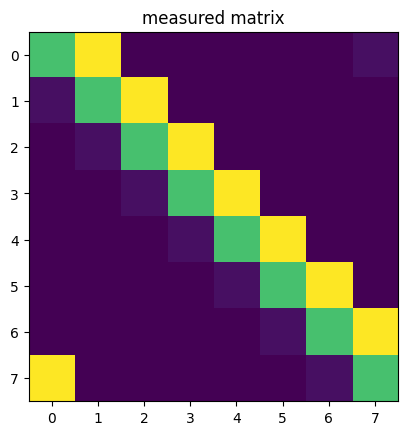

In [13]:
measured_mat = np.zeros([2**MAT_SIZE, 2**MAT_SIZE])

counter = 0
for r in res:
    my_state = get_projected_state_vector(r, "data")
    measured_mat[:, counter] = np.round(my_state, 10)
    counter += 1

measured_mat_factor = (max(np.abs(Ad))) * len(Ad)
measured_mat_normalized = measured_mat_factor * measured_mat

print(np.linalg.norm(np.abs(A) - np.abs(measured_mat_normalized)))

plt.imshow(measured_mat_normalized)
plt.title("measured matrix")

# Extracting the phases

In order to invert a matrix with QSVT we may cumpute classically the phases of QSP as in approximation to the the inversion function $ \frac{1}{x} $.
Its done by computing the coefficients of the inversion matrix given the desierd accuracy and the lower bound of the smallest eigen value.

The build-in function QuantumSignalProcessingPhases(..) takes the coefficient of descibed above and produces a list of phases that QSVT needed to be built.

b=2, j0=2
[PolyOneOverX] minimum [-1.088] is at [-0.8]: normalizing
[PolyOneOverX] bounding to 0.9
Polynom degree =  3


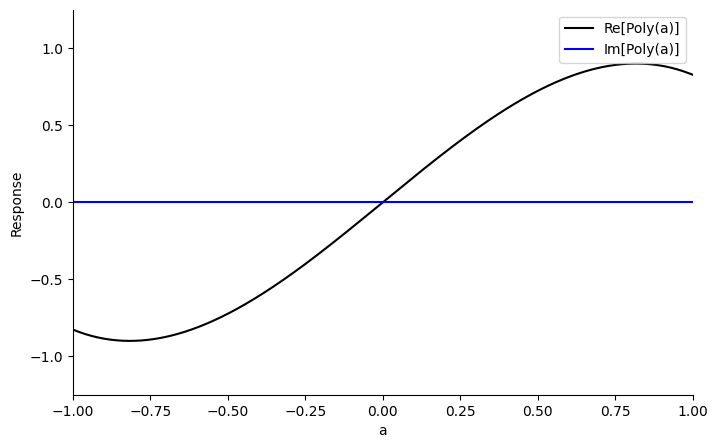

In [14]:
import pyqsp

w, _ = np.linalg.eig(A)
eig_val_in = np.sort(np.real(w))
pg = pyqsp.poly.PolyOneOverX()
PP_coeff = 1 / eig_val_in[0]
pcoefs = list(pg.generate(epsilon=0.1, kappa=PP_coeff))

poly = Polynomial(pcoefs)

QSVT_PHASES = QuantumSignalProcessingPhases(
    poly.coef, signal_operator="Wx", method="laurent", measurement="x"
)
print("Polynom degree = ", poly.degree())
pyqsp.response.PlotQSPResponse(QSVT_PHASES, signal_operator="Wx", measurement="x")

## Quantum Singular Value Transformation (QSVT)

The Quantum Singular Value Transformation (QSVT) is a powerful quantum algorithm that manipulates the singular values of a matrix encoded in a quantum state.
Starting by computing the QSP phases of the inersion function classically upon given accuracy, those phases are loaded to QSVT circuit desgined to 
manipulate the wigen values of matrix $ A $. 

### Key Steps in QSVT:

1. **Block-Encoding**:
   - The matrix $ A $ is embedded into a larger unitary matrix $U_A $, preserving its singular values.
   - This step ensures the matrix is compatible with quantum operations.

2. **Polynomial Approximation**:
   - QSVT applies a polynomial transformation $ P(x) $ to the singular values of $ A $.
   - To solve $ A \mathbf{x} = \mathbf{b} $, the polynomial is chosen as $ P(x) \approx \frac{1}{x} $.

3. **Result Extraction**:
   - After applying QSVT, the solution $ \mathbf{x} = A^{-1} \mathbf{b} $ is encoded in the quantum state.
   - This state can be measured or further processed to extract the solution.

### Implementation Plan:
1. Construct the block-encoded unitary $U_A $ from the matrix $ A $.
2. Design the QSVT circuit to apply $ P(x) $.
3. Execute the circuit using a quantum simulator and extract the solution.

For more details cite: https://arxiv.org/abs/2105.02859




In [15]:
@qfunc(synthesize_separately=True)
def my_projector_controlled_phase(phase: CReal, block: QNum, aux: QBit):
    control(block == 0, lambda: X(aux))
    RZ(phase, aux)
    control(block == 0, lambda: X(aux))


@qfunc(synthesize_separately=True)
def my_qsvt_step(
    phase1: CReal,
    phase2: CReal,
    u: QCallable[QArray, QArray],
    data: QArray[QBit],
    block: QArray[QBit],
    qsvt_aux: QBit,
):
    u(data, block)
    my_projector_controlled_phase(phase1, block, qsvt_aux)
    invert(lambda: u(data, block))
    my_projector_controlled_phase(phase2, block, qsvt_aux)


@qfunc(synthesize_separately=True)
def qsvt_inversion_my(
    qsvt_phases: CArray[CReal, len(QSVT_PHASES)],
    block: QNum,
    data: QNum,
    qsvt_aux: QBit,
):
    H(qsvt_aux)
    my_projector_controlled_phase(qsvt_phases[0], block, qsvt_aux)
    repeat(
        floor((qsvt_phases.len - 1) / 2),
        lambda i: my_qsvt_step(
            qsvt_phases[(2 * i) + 1],
            qsvt_phases[(2 * i) + 2],
            lambda d, b: my_be(d, b),
            data,
            block,
            qsvt_aux,
        ),
    )

    H(qsvt_aux)


def get_b_vector(b):
    return b.tolist()


def get_qprog_qsvt(b_normalized, constraints=None, preferences=Preferences(transpilation_option="none", timeout_seconds=600, optimization_level=0)) -> str:  # type: ignore[no-untyped-def]
    """
    This function gets a model and synthesizes it. It also sets the execution on a statevector
    """

    @qfunc(synthesize_separately=True)
    def main(block: Output[QNum], data: Output[QNum], qsvt_aux: Output[QBit]):

        allocate(1, qsvt_aux)
        allocate(DISTINTICITY + 1 + 1, block)
        prepare_amplitudes(get_b_vector(b_normalized), 0, data)
        qsvt_inversion_my(QSVT_PHASES, block, data, qsvt_aux)

    execution_preferences = ExecutionPreferences(
        num_shots=1,
        backend_preferences=ClassiqBackendPreferences(
            backend_name=ClassiqSimulatorBackendNames.SIMULATOR_STATEVECTOR
        ),
    )
    qmod = create_model(
        main,
        execution_preferences=execution_preferences,
        constraints=constraints,
        preferences=preferences,
    )
    qmod = set_execution_preferences(qmod, execution_preferences)
    qprog = synthesize(qmod)
    return qprog

## Results and Validation

problem formulation:

$ u^n - $ is the vector representation of the temperature of the stick at time n.
$ u^n = [u_0^n, u_1^n, \cdots, u_M^n]^T$

$ b^n - $ is the sum of the trmperature at time n-1 and boundary condition at time n.
$ b^n = [b_0^n, b_1^n, \cdots, b_M^n]^T$

$ A - $ Problem operator define as the sum of Laplacian operator multiplied by discret operator and identity.

So, we state the temperature at time n as a linear problem depends on time n-1 and the problem operator:

$ Au^n = b^n $

Suppose we aim to predict the temperatue distribution at time n.

1. **Problem initialization:**
    - $u^0=$ defined by initial condition.
    - $b^1=$ define as the sum of $u^0$ and the boundary condition.

2. **Main loop:**

    **for any i until n:**
    - $u^i = A^{-1} b^i$ 
    - $b^{i+1} = u^i + boundary condition$

Suppose we have quantum registers b and u holding the input and the result at each iteration. as stated above, first prepering the state of 
register b such that it holds the vector b (b must be normalisied)appling repitatlly QSVT circuit to compute u at time n.   



 



In [19]:
TIME = 2 / TIME_STEPS
N = int(np.round(TIME / dt + 0.5))
N

4

In [20]:
results = np.zeros([N, len(b_normalized)])
norms = np.ones([N, 1])
for i in range(N):
    results[i, ::] = np.prod(norms) * b_normalized
    qprog = get_qprog_qsvt(b_normalized)
    es = ExecutionSession(qprog)
    res = es.sample()
    my_state = get_projected_state_vector(res, "data")
    print(np.linalg.norm(my_state))
    norms[i] = np.linalg.norm(my_state)
    my_state = my_state / np.linalg.norm(my_state)
    b_normalized = my_state

0.12009881146643198
0.12039381687235061
0.12010040703113296
0.1204361612161837


In [21]:
show(qprog)

Quantum program link: https://platform.classiq.io/circuit/36qC1TLyypXGQCHDSHbm3OpWDtd


In [22]:
print(f"Width: {qprog.data.width}")

Width: 13


In [23]:
write_qmod(main, name="heat_eq_qsvt", decimal_precision=15)

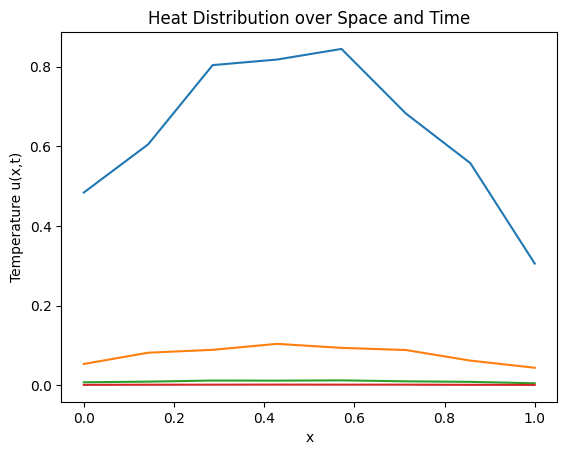

In [24]:
plt.figure()
plt.plot(x, norm_factor * results.transpose())
plt.title("Heat Distribution over Space and Time")
plt.xlabel("x")
plt.ylabel("Temperature u(x,t)")
plt.show()

In [27]:
assert 1 > (norm_factor * results[0][4]) > 0.7

In [30]:
assert 0.2 > (norm_factor * results[1][4]) > 0.01

np.True_